# COMP534 Lab Session 6
In this lab session, you will learn:

1. How to implement RNN using Pytorch
2. L2 regularization and Dropout
3. Transfer learning.

# 6.1 RNN

You will need to upload the data, provided on Canvas, into Google Colab to proceed with this practical.
To do this, you can simply upload the data, as previously explained in lab1-exercise.

Or, if you have a large dataset, you can upload it to your Google Drive and then link your Google Drive with Google Colab. To do this, you need to click on the Google Drive option:

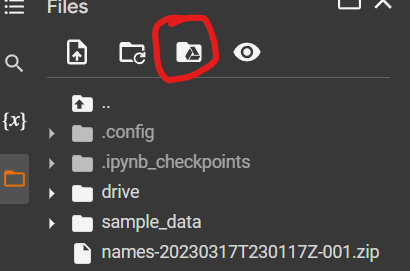

And then, run the following code:

```
from google.colab import drive
drive.mount('/content/drive')
```

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Classify Names with a Character-Level RNN

Up to now, we can implement the classification with feedforward neural networks.
Now, let's try to build a recurrent neural network (RNN) to complete the classification problem.


In this session, we build a basic character-lever RNN to classify the names from different languages,
so we can know how preprocessing for NLP modeling works at a low level rather than using many of the convenience functions of `torchtext`.


A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step.
We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


```

**Recommended Reading:**

Following the lectures in COMP534, there also list some useful information involved with PyTorch and RNN:

-  [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
-  [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Preparing the Data

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).


In [ ]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import torch

# glob module finds all the pathnames matching a specified pattern
import glob
# import ooperating system module
import os
import random
import numpy as np

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

Use the cell below to check if you can load your data.
Note that you may need to change the path to your data.

In [ ]:
# revise to your own data path
# for google drive
# print(findFiles('/content/drive/MyDrive/data/names/*.txt'))
print(glob.glob('./data/names/*.txt'))

The cell below is just performing some preprocessing by converting the names into ASCII letter. Check the examples to understand a little bit better.

In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("The number of all letters: ", n_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("unicode to Ascii: 'Ślusàrski' ", unicodeToAscii('Ślusàrski'))

### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g.

``"a" = <1 0 0 0 0 ...>``

``"b" = <0 1 0 0 0 ...>``

``"c" = <0 0 1 0 0 ...>``

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.


In [ ]:
import torch

# Find letter index from all_letters, index of n_letters
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# take example for the letter to tensor
print("Letter to tensor: ", letterToTensor('b'))

print(letterToTensor('b').size())

# take example for line to tensor
print(lineToTensor('Aston').size())
print(lineToTensor('Bob').size())
print(lineToTensor('Stephenson').size())
print(lineToTensor('Truscott').size())

Next, we need to combine all our examples into a dataset so we can train, test and validate our models.
For this, we will use the same `Dataset` and `DataLoader` classes to hold our dataset.
Each Dataset needs to implement three functions: `__init__`, `__len__`, and `__getitem__`.

In [ ]:
import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir  # for provenance of the dataset
        labels_set = set()  # set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        # read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        # This last bit converts the labels from string to number
        # Using the idea of encoding we saw during the lectures
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [ ]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

The long number you see above are the numeric one-hot encoding of the Arabic name `Khoury`.

Finally, let's split the data into training and validation - 80/20.

In [ ]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

## Creating the Network

Before PyTorch's `autograd`, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps.
The layers held hidden state and gradients which are now entirely handled by the `autograd` graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN network implements an RNN with three components. First, we use the [nn.RNN implementation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).
Next, we define a layer that maps the RNN hidden layers to our output. And finally, we apply a softmax function.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

# set the hidden neurons
n_hidden = 128
# instance a RNN model
rnn = RNN(n_letters, n_hidden, len(alldata.labels_uniq))

print(rnn)

After that we can pass our Tensor to the RNN to obtain a predicted output.
To do this, we need to pass an input (in our case, the Tensors for the current name), which we can obtain using the `lineToTensor` created previously.
The outcome generated by the network is the probability of each language.
We can use a helper function, `label_from_output`, to derive a text label for the numeric prediction generated by the network.


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

## Training





Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` ([Negative Log Likelihood Loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)) is appropriate, since the last layer of the RNN is ``nn.LogSoftmax``.

Observe that Negative Log Likelihood Loss combined with LogSoftMax is the same thing as a CrossEntropyLoss.



In [ ]:
# loss function
criterion = nn.NLLLoss()

We also create an ``optimizer`` which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.


In [ ]:
# If you set this too high, it might explode. If too low, it might not learn
learning_rate = 0.15

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and
   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
def train(rnn, training_data, n_epoch=10, n_batch_size = 64):
    current_loss = 0
    all_losses = []
    rnn.train()

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length!!
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: # for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)  # this is to facilitate convergence
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % 5 == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

Now we just have to run that with a bunch of examples.




In [ ]:
all_losses = train(rnn, train_set, n_epoch=27, n_batch_size=64)

### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backpropgation.


In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() # set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
evaluate(rnn, test_set, classes=alldata.labels_uniq)

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Spanish and Portuguese.




### Running on User Input




The code below allows you to get predictions on custom names.

In [ ]:
# define predict
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    rnn.eval()
    with torch.no_grad():
        output = rnn(lineToTensor(input_line))

        # Get top N categories
        topv, topi = torch.topk(output, n_predictions, 1)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, alldata.labels_uniq[category_index]))
            predictions.append([value, alldata.labels_uniq[category_index]])

In [ ]:
# take some examples
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Zhang')
predict('Ceallachan')

predict('Dong')
predict('Duong')
predict('Duan')

## Exercise

Get better results with a bigger and/or better shaped network